# Описание проекта:

**Цель:** Создать модель машинного обучения для предсказания стоимости недвижимости в Раменском и Жуковском (Подмосковье) с использованием данных, полученных с помощью библиотеки Cianparser.

**Целевая аудитория:**

* Жители Раменского и Жуковского, владеющие недвижимостью и желающие оценить её стоимость.
* Люди, планирующие переезд в Раменское или Жуковский и интересующиеся ценами на недвижимость.

**Инструменты:**

* Python
* Библиотека Cianparser для сбора данных
* Библиотеки машинного обучения (Scikit-learn)
* Streamlit для создания интерактивного приложения

**Ожидаемые результаты:**

* Модель машинного обучения с MAPE <= 0.2, способная точно предсказывать стоимость недвижимости.
* Интерактивное приложение Streamlit, позволяющее пользователям вводить характеристики недвижимости и получать прогноз цены.

## Импорты

In [177]:
import pyforest

import pandas as pd
import numpy as np
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (mean_absolute_percentage_error, mean_absolute_error,
                             mean_squared_error, mean_squared_log_error,
                             median_absolute_error, r2_score)

from pycaret.regression import *

import skimpy
import chime
from geopy.geocoders import Nominatim
from geopy.distance import geodesic

chime.theme('mario')
%load_ext chime

# RANDOM SEED (RANDOM STATE)
S = 100500

The chime extension is already loaded. To reload it, use:
  %reload_ext chime


In [178]:
plt.style.use('dark_background')

In [179]:
geolocator = Nominatim(user_agent="my_app", timeout=60)

## Загрузка и Обзор данных

In [180]:
df = pd.read_csv('suburban.csv',parse_dates=['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2948 entries, 0 to 2947
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   author                2926 non-null   object        
 1   author_type           2927 non-null   object        
 2   url                   2948 non-null   object        
 3   location              2948 non-null   object        
 4   deal_type             2948 non-null   object        
 5   accommodation_type    2948 non-null   object        
 6   suburban_type         2948 non-null   object        
 7   price                 2948 non-null   int64         
 8   year_of_construction  2948 non-null   object        
 9   house_material_type   2948 non-null   object        
 10  land_plot             2948 non-null   object        
 11  land_plot_status      2948 non-null   object        
 12  heating_type          2948 non-null   int64         
 13  gas_type          

In [181]:
skimpy.skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 2948   │ │ string      │ 18    │                                                          │
│ │ Number of columns │ 29     │ │ int32       │ 8     │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 2     │                                                          │
│                                │ datetime64  │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━┳━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_na ┃     ┃           ┃           ┃           ┃          ┃           ┃          ┃           ┃        ┃  │
│ ┃ me        ┃ NA  ┃ NA %      ┃ mean      ┃ sd        ┃ p0       ┃ p25       ┃ p75      ┃ p100      ┃ hist   ┃  │
│ ┡━━━━━━━━━━━╇━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━┩  │
│ │ price     │   0 │         0 │  39000000 │  84000000 │   590000 │  11000000 │ 32000000 │ 140000000 │   █    │  │
│ │           │     │           │           │           │          │           │          │         0 │        │  │
│ │ heating_t │   0 │         0 │        -1 │         0 │       -1 │        -1 │       -1 │        -1 │     █  │  │
│ │ ype       │     │           │           │           │          │           │          │           │        │  │
│ │ gas_type  │   0 │         0 │        -1 │         0 │       -1 │        -1 │       -1 │        -1 │     █  │  │
│ │ water_sup │   0 │         0 │        -1 │         0 │       -1 │        -1 │       -1 │        -1 │     █  │  │
│ │ ply_type  │     │           │           │           │          │           │          │           │        │  │
│ │ sewage_sy │   0 │         0 │        -1 │         0 │       -1 │        -1 │       -1 │        -1 │     █  │  │
│ │ stem      │     │           │           │           │          │           │          │           │        │  │
│ │ bathroom  │   0 │         0 │        -1 │         0 │       -1 │        -1 │       -1 │        -1 │     █  │  │
│ │ floors_co │   0 │         0 │       1.9 │       1.4 │       -1 │         2 │        3 │        42 │   █    │  │
│ │ unt       │     │           │           │           │          │           │          │           │        │  │
│ │ phone     │   0 │         0 │ -71000000 │ 170000000 │ -2000000 │ -20000000 │ 18000000 │ 200000000 │ █    ▄ │  │
│ │           │     │           │         0 │         0 │      000 │        00 │       00 │         0 │        │  │
│ │ price_per │ 394 │ 13.364993 │        -1 │         0 │       -1 │        -1 │       -1 │        -1 │     █  │  │
│ │ _month    │     │ 215739485 │           │           │          │           │          │           │        │  │
│ │ commissio │ 394 │ 13.364993 │         0 │         0 │        0 │         0 │        0 │         0 │     █  │  │
│ │ ns        │     │ 215739485 │           │           │          │           │          │           │        │  │
│ └───────────┴─────┴───────────┴───────────┴───────────┴──────────┴───────────┴──────────┴───────────┴────────┘  │
│                                                    dat

In [182]:
df.sample(1).T

,1987
author,ID 7402587
author_type,homeowner
url,https://www.cian.ru/sale/suburban/300500031/
location,Москва
deal_type,sale
accommodation_type,suburban
suburban_type,townhouse
price,27500000
year_of_construction,2013
house_material_type,Кирпичный


In [183]:
ignore_cols = ['author','url','deal_type','house_number','phone','commissions','price_per_month','address','coordinates']

In [184]:
target = 'price'

In [185]:
df['year_of_construction'] = df[['year_of_construction']].replace(['Напишите автору','Позвоните автору'],'-1').astype('int')

In [186]:
def convert_coords(coords):
    """
    Преобразует строку или кортеж с координатами в кортеж.

    Args:
        coords (str or tuple): Строка с координатами в формате "(latitude, longitude)" 
                               или кортеж (latitude, longitude).

    Returns:
        tuple: Кортеж с координатами (latitude, longitude).
    """
    if isinstance(coords, str):
        lat, lon = map(float, coords.strip("()").split(", "))
        return (lat, lon)
    elif isinstance(coords, tuple):
        return coords
    else:
        return None

In [187]:
df['coordinates'] = df['coordinates'].apply(convert_coords)

In [188]:
def get_city_center(city_name, add_location = False, location='Москва'):
    """
    Получает координаты центра населённого пункта.

    Args:
        city_name (str): Название населённого пункта.

    Returns:
        tuple: Координаты (latitude, longitude) центра населённого пункта, если найдены, иначе None.
    """
    MO = 'Московская область, '

    try:
        city_center = geolocator.geocode(MO+city_name)
        if (city_center is not None and
            city_center.latitude < 57 
            and city_center.latitude >= 54.2
            and city_center.longitude >= 35.12 
            and city_center.longitude <= 40.2):
            return (city_center.latitude, city_center.longitude)
        
        else: 
            if add_location == True:
                city_center = geolocator.geocode(MO+location+', '+city_name)
                if (city_center is not None and
                    city_center.latitude < 57 
                    and city_center.latitude >= 54.2
                    and city_center.longitude >= 35.12 
                    and city_center.longitude <= 40.2):
                    return (city_center.latitude, city_center.longitude)
                
                else:
                    city_center = geolocator.geocode(location+', '+city_name)
                    if (city_center is not None and
                        city_center.latitude < 57 
                        and city_center.latitude >= 54.2
                        and city_center.longitude >= 35.12 
                        and city_center.longitude <= 40.2):
                        return (city_center.latitude, city_center.longitude)
                
                    else:
                            return None
            else:
                    return None
    except:
        return None
    
city_centers = {}
for city in df['location'].unique():
    city_centers[city] = get_city_center(city)
city_centers

{'Жуковский': (55.5972801, 38.1199863),
 'Раменское': (55.5709361, 38.2282099),
 'Видное': (55.5571496, 37.7087142),
 'Москва': (55.7098009, 37.0536908),
 'Одинцово': (55.678223, 37.2668096),
 'Домодедово': (55.40912105, 37.904166212415895),
 'Реутов': (55.7622453, 37.856555),
 'Долгопрудный': (55.9341491, 37.5142417),
 'Железнодорожный': (55.7464587, 38.0090773),
 'Подольск': (55.4308841, 37.5453056),
 'Красногорск': (55.8217545, 37.3400897),
 'Балашиха': (55.7997662, 37.9373707)}

In [189]:
get_city_center('м. Троицк', add_location=True, location='Москва') 

(55.5466018, 37.1580029)

In [190]:
metro_stations = {}
for station in df['underground'].unique():
    if pd.notna(station):  # Проверка на пропущенные значения
        metro_stations[station] = get_city_center(station, add_location = True)
metro_stations

{'м. Кратово': (55.5932015, 38.1584421),
 'м. Отдых': (55.3835057, 38.20580328700579),
 'м. Ильинская': (55.5255215, 36.0200801),
 'м. Удельная': (55.6359979, 38.0448181),
 'м. Есенинская': (55.8243203, 37.2500446),
 'м. Котельники': (55.661668, 37.8673073),
 'м. Ипподром': None,
 'м. Раменское': (55.5709361, 38.2282099),
 'м. Фабричная': (55.9773275, 37.7445274),
 'м. Выхино': (55.7082107, 37.811757),
 'м. Домодедовская': (55.4327533, 37.7594972),
 'м. Битца': (55.5689975, 37.6141105),
 'м. Бирюлёво': (55.5896897, 37.6569745),
 'м. Бутово': (55.2909642, 39.446982),
 'м. Царицыно': (55.5579875, 37.7711061),
 'м. Щербинка': (55.4352014, 37.6484001),
 'м. Аннино': (54.3801761, 38.6682371),
 'м. Троицк': (55.5466018, 37.1580029),
 'м. Подольск': (55.4308841, 37.5453056),
 'м. Тёплый Стан': (55.6259323, 37.4938342),
 'м. Коммунарка': (55.5703217, 37.4757622),
 'м. Крёкшино': (55.5466018, 37.1580029),
 'м. Бунинская аллея': (55.5312145, 37.5188065),
 'м. Физтех': None,
 'м. Внуково': (56.36

In [247]:

def calculate_distance(row, target_location, replace_nans = False, target_name="target", cup=None):
    """
    Рассчитывает расстояние от объекта недвижимости до заданной точки в километрах.

    Args:
        row (pd.Series): Строка DataFrame, содержащая информацию об объекте недвижимости.
        target_location (tuple): Координаты (latitude, longitude) целевой точки.
        replace_nans (bool): если True, то при наличии пропуска в координатах за координаты обьекта принимается
        центр населённого пункта (location)
        target_name (str): Название целевой точки для имени столбца.

    Returns:
        float: Расстояние в километрах, если координаты объекта известны, иначе NaN. 
    """
    if row['coordinates'] and pd.notna(target_location):
        distance = geodesic(row['coordinates'], target_location).km
        result = distance
    else:
        if replace_nans and pd.notna(target_location):
            distance = geodesic(city_centers[row['location']], target_location).km
            result = distance
        else:
            result = np.NaN

    if cup and result != np.NaN and result > cup:
        result = np.NaN
        
    return result
        
def get_nearest_metro(row, metro_stations):
    """
    Находит ближайшую станцию метро к объекту недвижимости.

    Args:
        row (pd.Series): Строка DataFrame, содержащая информацию об объекте недвижимости.
        metro_stations (dict): Словарь с координатами станций метро.

    Returns:
        tuple: Координаты (latitude, longitude) ближайшей станции метро, если найдена, иначе None.
    """
    if row['coordinates'] and pd.notna(row['underground']):  # Проверка наличия координат и названия станции
        return metro_stations[row['underground']]
    else:
        return None
    
def add_metro_status(row):
    """
    Возращает статус метро.

    Args:
        row (pd.Series): Строка DataFrame, содержащая информацию об объекте недвижимости.

    Returns:
        str: 'no' если нет метро, 'no coordinates' если нет координат, иначе 'yes'.
    """

    if not row['underground'] or pd.isna(row['underground']):
        return 'no'
    elif not row['distance_to_metro'] or pd.isna(row['distance_to_metro']):
        return 'no coordinates'
    else:
        return 'yes'

In [192]:
df['distance_to_moscow'] = df.apply(lambda row: calculate_distance(row, 
                                                                    city_centers['Москва'],
                                                                    replace_nans = True),
                                                                      axis=1)

df['distance_to_city_center'] = df.apply(lambda row: calculate_distance(row, 
                                                                        city_centers[row['location']]),
                                                                         axis=1)

In [193]:
uncorrect_cords = df.loc[df['distance_to_moscow'] > 170]
uncorrect_cords[['distance_to_moscow']]

,distance_to_moscow
30,325.383667
35,3321.069631
44,321.931191
45,325.725576
60,325.383667
80,325.383667
81,314.107308
443,6245.819016
571,1455.985072
977,3004.178028


In [194]:
from functions import *

In [195]:
coordinates = []
for index, row in tqdm(uncorrect_cords.iterrows(), total=uncorrect_cords.shape[0]):
    coordinates.append(geocode_address(row, all_country = False))

uncorrect_cords['coordinates'] = coordinates

num_missing_coords = uncorrect_cords['coordinates'].isna().sum()
num_geocoded = len(uncorrect_cords) - num_missing_coords
print(f"Количество объектов с координатами: {num_geocoded}")
print(f"Количество объектов без координат: {num_missing_coords}")

100%|██████████| 16/16 [00:55<00:00,  3.49s/it]

Количество объектов с координатами: 5
Количество объектов без координат: 11


In [196]:
uncorrect_cords['distance_to_moscow'] = uncorrect_cords.apply(lambda row: calculate_distance(row, 
                                                                        city_centers['Москва'],
                                                                        replace_nans = True),
                                                                        axis=1)
uncorrect_cords['distance_to_city_center'] = uncorrect_cords.apply(lambda row: calculate_distance(row, 
                                                                        city_centers[row['location']]),
                                                                        axis=1)

uncorrect_cords[['distance_to_moscow','distance_to_city_center']]

,distance_to_moscow,distance_to_city_center
30,68.281376,NaN
35,68.281376,NaN
44,66.376028,2.179817
45,68.281376,NaN
60,68.281376,NaN
80,68.281376,NaN
81,68.281376,NaN
443,43.994765,2.146939
571,20.318347,20.318347
977,58.200634,58.200634


In [197]:
(df.loc[df['distance_to_moscow'] > 170, 
['coordinates','distance_to_moscow',
 'distance_to_city_center']]) = uncorrect_cords[['coordinates',
                                                'distance_to_moscow',
                                                'distance_to_city_center']]

In [248]:
df['nearest_metro'] = df.apply(get_nearest_metro, args=(metro_stations,), axis=1)
df['distance_to_metro'] = df.apply(lambda row: calculate_distance(row, 
                                                    row['nearest_metro'], replace_nans = False,
                                                    cup = 25), axis=1)
df['metro_status'] = df.apply(add_metro_status, axis=1)

<Axes: xlabel='distance_to_metro'>

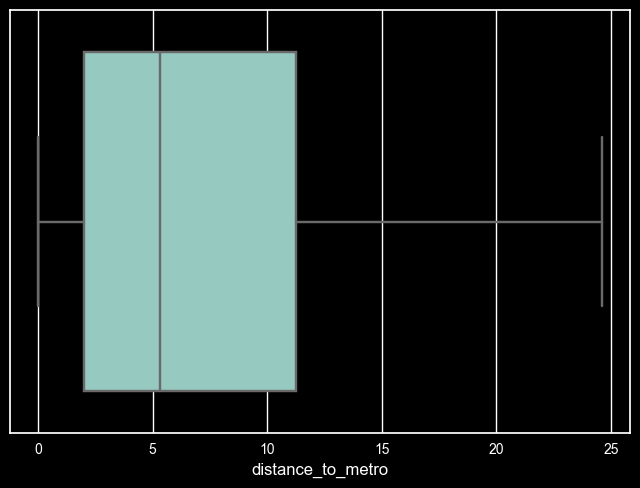

In [199]:
sns.boxplot(df['distance_to_metro'])

In [201]:
cat_cols = df.select_dtypes(exclude=['number','datetime']).columns
cat_cols

Index(['author', 'author_type', 'url', 'location', 'deal_type',
       'accommodation_type', 'suburban_type', 'house_material_type',
       'land_plot', 'land_plot_status', 'living_meters', 'district',
       'underground', 'street', 'house_number', 'address', 'coordinates',
       'nearest_metro', 'metro_status'],
      dtype='object')

In [205]:
ignore_cols += ['nearest_metro','address','coordinates']

In [206]:
num_cols = df.select_dtypes(include=['number']).columns
num_cols

Index(['price', 'year_of_construction', 'heating_type', 'gas_type',
       'water_supply_type', 'sewage_system', 'bathroom', 'floors_count',
       'phone', 'price_per_month', 'commissions', 'distance_to_moscow',
       'distance_to_city_center', 'distance_to_metro'],
      dtype='object')

In [203]:
date_cols = df.select_dtypes(include=['datetime']).columns
date_cols

Index(['date'], dtype='object')

In [250]:
for col in cat_cols:
    if col not in ignore_cols:
        display(df[[col]].value_counts())

author_type            
real_estate_agent          1736
realtor                     646
homeowner                   338
developer                    95
unknown                      95
official_representative      17
dtype: int64

location       
Москва             1724
Раменское           333
Балашиха            234
Подольск            116
Красногорск         114
Жуковский            98
Домодедово           83
Видное               76
Одинцово             68
Долгопрудный         62
Железнодорожный      32
Реутов                8
dtype: int64

suburban_type
house            2140
townhouse         643
land-plot         143
house-part         22
dtype: int64

house_material_type
Кирпичный              942
-1                     652
Деревянный             355
Газобетонный блок      300
Монолитный             188
Каркасный              166
Пенобетонный блок      160
Газосиликатный блок    101
Блочный                 53
Щитовой                 20
Монолитно-кирпичный      7
Панельный                4
dtype: int64

land_plot 
6 сот.        354
10 сот.       159
-1            152
5 сот.        146
8 сот.        136
             ... 
15,62 сот.      1
4,22 сот.       1
4,16 сот.       1
4,15 сот.       1
4,12 сот.       1
Length: 527, dtype: int64

land_plot_status 
-1                   2820
ИЖС                    89
Садоводство            33
ЛПХ                     4
Фермерское хоз-во       2
dtype: int64

living_meters
-1               560
150 м²            69
160 м²            57
200 м²            53
120 м²            51
                ... 
231 м²             1
232,5 м²           1
234,7 м²           1
234,8 м²           1
9 м²               1
Length: 828, dtype: int64

district              
Первомайское поселение    250
р-н Северный              217
Вороновское поселение     141
Марушкинское поселение    136
Сосенское поселение       133
                         ... 
р-н Останкинский            1
р-н Ново-Переделкино        1
р-н Марьина роща            1
р-н Кунцево                 1
р-н Северное Тушино         1
Length: 62, dtype: int64

underground    
м. Крёкшино        224
м. Подольск        178
м. Ипподром        132
м. Филатов Луг      97
м. Апрелевка        69
                  ... 
м. Реутов            1
м. Киевская          1
м. Балтийская        1
м. Сокол             1
м. Юго-Западная      1
Length: 126, dtype: int64

street              
м. Бунинская аллея      37
улица Центральная       35
улица Озерная           27
улица Троицкая          15
Аптекарская улица       14
                        ..
улица 2-я Прудовая       1
улица 2-я Осенняя        1
улица 2-я Майская        1
улица 2-я Вокзальная     1
улица Веселая            1
Length: 641, dtype: int64

metro_status  
yes               1233
no coordinates     961
no                 754
dtype: int64

In [251]:
ignore_cols.append('street')

In [208]:
for col in num_cols:
    if col not in ignore_cols:
        display(df[[col]].value_counts())

price     
25000000      42
12000000      36
27000000      33
15000000      31
11000000      30
              ..
15490000       1
15594000       1
15672000       1
15680000       1
1401613500     1
Length: 927, dtype: int64

year_of_construction
-1                      1266
 2023                    258
 2024                    144
 2022                    144
 2014                     84
                        ... 
 1967                      1
 1977                      1
 1983                      1
 1984                      1
 2025                      1
Length: 68, dtype: int64

heating_type
-1              2948
dtype: int64

gas_type
-1          2948
dtype: int64

water_supply_type
-1                   2948
dtype: int64

sewage_system
-1               2948
dtype: int64

bathroom
-1          2948
dtype: int64

floors_count
 2              1581
 3               660
 1               301
-1               292
 4               110
 5                 3
 42                1
dtype: int64

distance_to_moscow
75.558184             184
25.223939             152
0.000000              108
43.486166             106
30.401135             105
                     ... 
34.895542               1
34.904218               1
34.936185               1
35.097765               1
35.528662               1
Length: 935, dtype: int64

distance_to_city_center
0.000000                   441
25.223939                  152
43.486166                  106
30.401135                  105
16.544779                   83
                          ... 
13.061631                    1
13.100018                    1
2.696984                     1
2.693614                     1
14.246494                    1
Length: 925, dtype: int64

distance_to_metro
0.000000             98
6.059900             97
11.372709            49
3.925768             43
12.754584            34
                     ..
2.631160              1
2.614198              1
2.606233              1
2.603486              1
24.608120             1
Length: 588, dtype: int64

In [211]:
df.loc[df['floors_count'] == 42,'floors_count'] = 2

In [218]:
ignore_cols += ['heating_type','gas_type','water_supply_type','sewage_system','bathroom','accommodation_type']

In [252]:
ignore_cols

['author',
 'url',
 'deal_type',
 'house_number',
 'phone',
 'commissions',
 'price_per_month',
 'address',
 'coordinates',
 'nearest_metro',
 'address',
 'coordinates',
 'heating_type',
 'gas_type',
 'water_supply_type',
 'sewage_system',
 'bathroom',
 'accommodation_type',
 'street']

In [253]:
good_cols = df.columns[[x not in ignore_cols for x in df.columns]]

In [254]:
df[good_cols]

,author_type,location,suburban_type,price,year_of_construction,house_material_type,land_plot,land_plot_status,living_meters,floors_count,district,underground,date,distance_to_moscow,distance_to_city_center,distance_to_metro,metro_status
0,real_estate_agent,Жуковский,house,5000000,-1,Кирпичный,15 сот.,-1,45 м²,1,NaN,м. Кратово,2024-04-22,66.795216,1.888216,4.131692,yes
1,homeowner,Жуковский,house,18800000,2021,Газобетонный блок,"2,7 сот.",-1,145 м²,2,NaN,м. Отдых,2024-04-22,68.866944,1.623591,22.789846,yes
2,real_estate_agent,Жуковский,house,7950000,2010,Газосиликатный блок,"1,3 сот.",-1,"73,3 м²",2,NaN,м. Отдых,2024-04-22,68.532038,2.745923,21.846554,yes
3,real_estate_agent,Жуковский,house,9497000,2023,Каркасный,"3,5 сот.",-1,120 м²,2,NaN,м. Отдых,2024-04-22,68.219905,0.069858,24.405074,yes
4,realtor,Жуковский,house,5500000,-1,Деревянный,4 сот.,-1,56 м²,2,NaN,м. Кратово,2024-04-22,68.281376,0.000000,2.466539,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2943,homeowner,Подольск,townhouse,5200000,-1,Кирпичный,10 сот.,-1,50 м²,-1,NaN,NaN,2024-04-26,47.159623,3.927699,NaN,no
2944,real_estate_agent,Подольск,townhouse,10900000,-1,Газобетонный блок,6 сот.,-1,120 м²,2,NaN,NaN,2024-04-26,43.886776,0.000000,NaN,no
2945,developer,Балашиха,house,59300000,-1,Кирпичный,"5,19 сот.",-1,240 м²,2,NaN,NaN,2024-04-26,54.940302,4.669660,NaN,no
2946,developer,Балашиха,house,39375000,-1,Кирпичный,"5,07 сот.",-1,240 м²,2,NaN,NaN,2024-04-26,54.940302,4.669660,NaN,no


In [19]:
good_cols

Index(['author_type', 'location', 'suburban_type', 'price',
       'year_of_construction', 'house_material_type', 'land_plot',
       'land_plot_status', 'living_meters', 'floors_count', 'district',
       'underground', 'date'],
      dtype='object')

In [255]:
def clean_land_plot(x):
    if x == '-1':
        return -1
    else:
        x = x.replace("\xa0", "")  # удаление всех неразрывных пробелов
        x = x.replace(",", ".")
        if 'га' in x:
            x = x.replace("га", "")
            return float(x) * 100
        elif 'сот.' in x:
            x = x.replace("сот.", "")
            return float(x)
        else:
            try:
                return float(x)
            except:
                return -1

df['land_plot'] = df['land_plot'].apply(clean_land_plot)

In [256]:
def clean_living_meters(x):
    if x == '-1':
        return -1
    else:
        x = x.replace("\xa0", "")  # удаление всех неразрывных пробелов
        x = x.replace(",", ".")
        x = x.replace("м²", "")
        return float(x)

df['living_meters'] = df['living_meters'].apply(clean_living_meters)

In [257]:
df[['land_plot','living_meters']]

,land_plot,living_meters
0,15.00,45.0
1,2.70,145.0
2,1.30,73.3
3,3.50,120.0
4,4.00,56.0
...,...,...
2943,10.00,50.0
2944,6.00,120.0
2945,5.19,240.0
2946,5.07,240.0


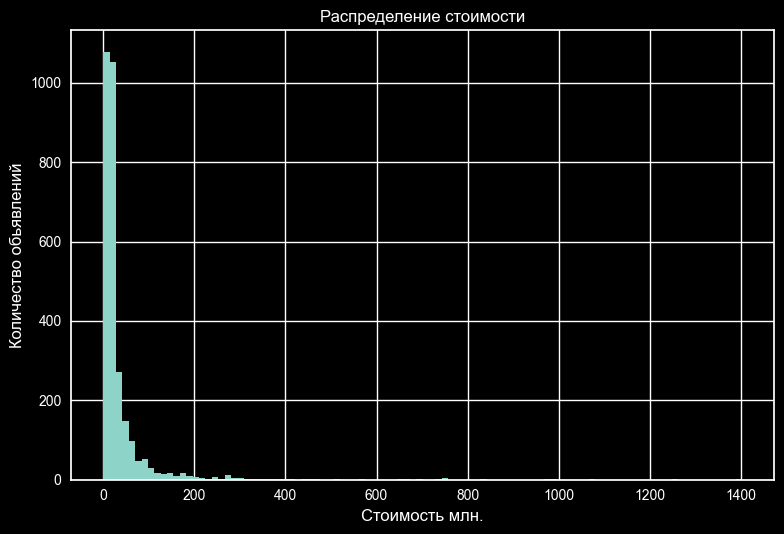

In [258]:
(df[[target]]/1_000_000).hist(bins=100)

plt.title('Распределение стоимости')
plt.ylabel('Количество обьявлений')
plt.xlabel('Стоимость млн.')
plt.tight_layout()
plt.show()

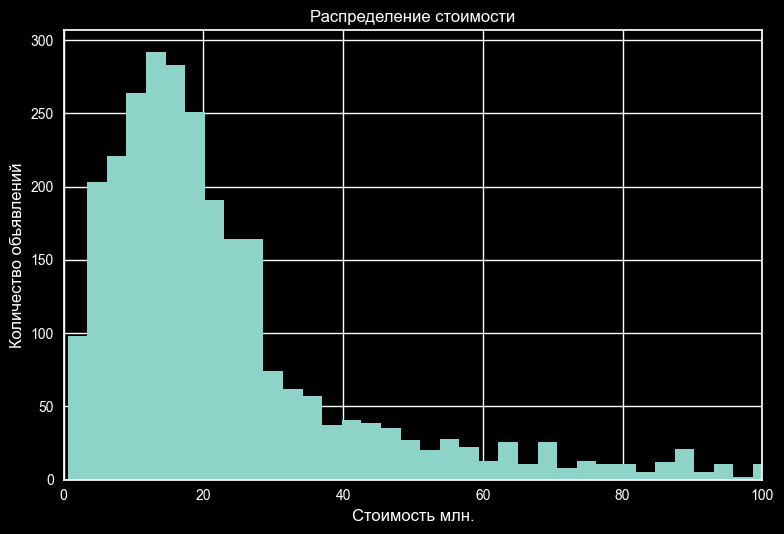

In [259]:
(df[[target]]/1_000_000).hist(bins=500)

plt.title('Распределение стоимости')
plt.ylabel('Количество обьявлений')
plt.xlabel('Стоимость млн.')
plt.xlim(0,100)
plt.tight_layout()
plt.show()

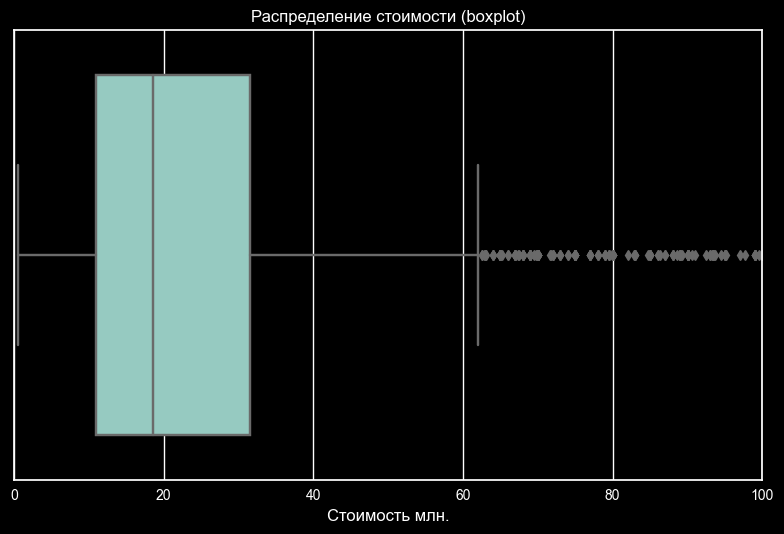

In [260]:
sns.boxplot(data=df[[target]]/1_000_000,x=target)

plt.title('Распределение стоимости (boxplot)')
plt.xlabel('Стоимость млн.')
plt.xlim(0,100)
plt.tight_layout()
plt.show()

In [269]:
num_cols = df.select_dtypes(include=['number']).columns.to_list()
cat_cols = df.select_dtypes(exclude=['number','datetime']).columns.to_list()
df[num_cols] = df[num_cols].replace(-1, np.NaN)
df[cat_cols] = df[cat_cols].replace('-1', np.NaN)
replace_id = (df[df['suburban_type'] == 'land-plot']
            [df['land_plot'].isna()==False]
            [['suburban_type']]).index
df.loc[replace_id,'suburban_type'] = 'house'

In [273]:
# prep_df = df[df['suburban_type']=='house'].reset_index(drop=True)
prep_df = df.copy().reset_index(drop=True)
ignore_cols.append('date')

In [275]:
prep_df

,author,author_type,url,location,deal_type,accommodation_type,suburban_type,price,year_of_construction,house_material_type,...,date,price_per_month,commissions,address,coordinates,distance_to_moscow,distance_to_city_center,nearest_metro,distance_to_metro,metro_status
0,ЕГСН Продажа,real_estate_agent,https://zhukovsky.cian.ru/sale/suburban/292484...,Жуковский,sale,suburban,house,5000000,-1,Кирпичный,...,2024-04-22,NaN,NaN,"3-я линия, Жуковский","(55.5896874, 38.0932055)",66.795216,1.888216,"(55.5932015, 38.1584421)",4.131692,yes
1,ID 17210260,homeowner,https://zhukovsky.cian.ru/sale/suburban/296176...,Жуковский,sale,suburban,house,18800000,2021,Газобетонный блок,...,2024-04-22,NaN,NaN,"шоссе Туполевское, Жуковский","(55.5828968, 38.1242334)",68.866944,1.623591,"(55.3835057, 38.20580328700579)",22.789846,yes
2,Владис Новый Город,real_estate_agent,https://zhukovsky.cian.ru/sale/suburban/300268...,Жуковский,sale,suburban,house,7950000,2010,Газосиликатный блок,...,2024-04-22,NaN,NaN,"Кооперативная улица, Жуковский","(55.5727959, 38.1147412)",68.532038,2.745923,"(55.3835057, 38.20580328700579)",21.846554,yes
3,Центральное,real_estate_agent,https://zhukovsky.cian.ru/sale/suburban/300876...,Жуковский,sale,suburban,house,9497000,2023,Каркасный,...,2024-04-22,NaN,NaN,"улица Фрунзе, Жуковский","(55.5970931, 38.1189285)",68.219905,0.069858,"(55.3835057, 38.20580328700579)",24.405074,yes
4,Лариса Бойцова,realtor,https://zhukovsky.cian.ru/sale/suburban/301007...,Жуковский,sale,suburban,house,5500000,-1,Деревянный,...,2024-04-22,NaN,NaN,Жуковский,"(55.5972801, 38.1199863)",68.281376,0.000000,"(55.5932015, 38.1584421)",2.466539,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2943,ID 56594583,homeowner,https://chekhov.cian.ru/sale/suburban/292848690/,Подольск,sale,suburban,townhouse,5200000,-1,Кирпичный,...,2024-04-26,-1.0,0.0,"Россия, Московская область, Лесная улица, Подо...","(55.3961195, 37.5558615)",47.159623,3.927699,None,NaN,no
2944,Landis,real_estate_agent,https://podolsk.cian.ru/sale/suburban/296187870/,Подольск,sale,suburban,townhouse,10900000,-1,Газобетонный блок,...,2024-04-26,-1.0,0.0,"Россия, Московская область, Подольск","(55.4308841, 37.5453056)",43.886776,0.000000,None,NaN,no
2945,KASKAD Недвижимость,developer,https://balashikha.cian.ru/sale/suburban/29988...,Балашиха,sale,suburban,house,59300000,-1,Кирпичный,...,2024-04-26,-1.0,0.0,"Россия, Московская область, Аптекарская улица,...","(55.7585086, 37.9239876)",54.940302,4.669660,None,NaN,no
2946,KASKAD Недвижимость,developer,https://balashikha.cian.ru/sale/suburban/29988...,Балашиха,sale,suburban,house,39375000,-1,Кирпичный,...,2024-04-26,-1.0,0.0,"Россия, Московская область, Аптекарская улица,...","(55.7585086, 37.9239876)",54.940302,4.669660,None,NaN,no


## Обучение модели

### Пробные эксперементы

In [290]:
cat_features = df[good_cols].select_dtypes(exclude=['number','datetime']).columns.to_list()
num_features = df[good_cols].select_dtypes(include=['number']).columns[1:].to_list()

In [292]:
prep_df_fill_cat_nans = prep_df.copy()
prep_df_fill_cat_nans[cat_features] =  prep_df[cat_features].fillna('___')

### новый эксперемент

In [317]:
S = 42

In [324]:
%%chime 

exp = setup(prep_df_fill_cat_nans,target=target, ignore_features = ignore_cols,
        imputation_type = 'iterative', categorical_iterative_imputer = 'xgboost',
        numeric_iterative_imputer = 'xgboost', numeric_features=num_features,
        iterative_imputation_iters = 10, categorical_features=cat_features,
        train_size=0.8, fold=20, session_id=S, normalize=True)
            
best_model = exp.compare_models(include=['lightgbm','xgboost','gbr','rf','et','catboost','dummy'])

,Description,Value
0,Session id,42
1,Target,price
2,Target type,Regression
3,Original data shape,"(2948, 34)"
4,Transformed data shape,"(2948, 52)"
5,Transformed train set shape,"(2358, 52)"
6,Transformed test set shape,"(590, 52)"
7,Ignore features,20
8,Numeric features,7
9,Categorical features,8


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,15798664.7157,2688053542766441.0000,47409744.4364,0.5184,0.4948,0.4563,3.3470
et,Extra Trees Regressor,15532635.4778,2764740075480541.5000,47793482.2449,0.4680,0.4811,0.4608,1.8455
lightgbm,Light Gradient Boosting Machine,16789843.5014,2923255960011355.0000,49102939.6882,0.4297,0.5302,0.5001,1.4600
rf,Random Forest Regressor,16829343.8386,3656902692089146.5000,55004817.3352,0.3459,0.4868,0.4699,1.9655
gbr,Gradient Boosting Regressor,17390465.4316,3382487663249393.0000,53133217.2739,0.2973,0.5650,0.5836,1.3325
xgboost,Extreme Gradient Boosting,17750528.6963,3756892177675543.5000,57920246.6772,0.1409,0.5296,0.4838,1.1505
dummy,Dummy Regressor,33621675.4421,6424413654408457.0000,74513145.9966,-0.0414,1.1855,2.1829,1.0080


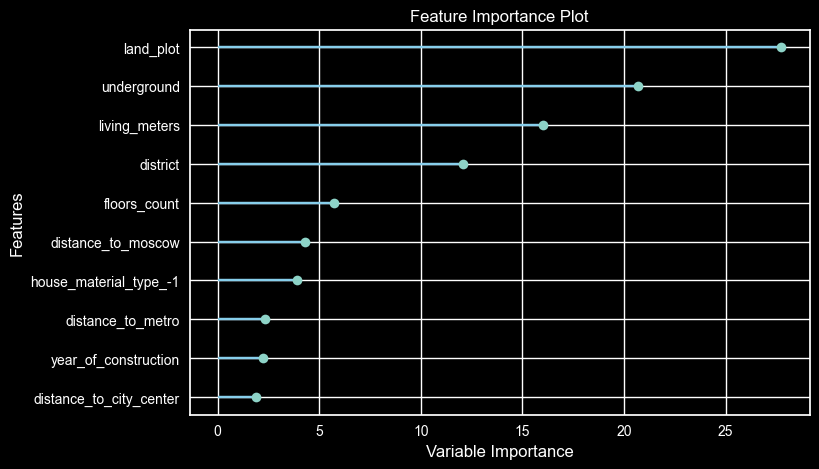

In [325]:
plot_model(best_model,'feature')

In [326]:
predict_model(best_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,18797143.2324,3724566737455315.5000,61029228.5504,0.6165,0.5404,0.5191


,author_type,location,suburban_type,year_of_construction,house_material_type,land_plot,land_plot_status,living_meters,floors_count,district,underground,distance_to_moscow,distance_to_city_center,distance_to_metro,metro_status,price,prediction_label
565,real_estate_agent,Москва,house,2005,Кирпичный,19.73,-1,-1.000000,3,р-н Крылатское,м. Крылатское,21.653955,21.653955,NaN,no coordinates,440000000,1.756005e+08
1220,real_estate_agent,Москва,house,-1,-1,5.00,-1,140.000000,2,Щаповское поселение,м. Охотный ряд,41.821907,41.821907,NaN,no coordinates,12300000,1.487035e+07
2797,homeowner,Балашиха,townhouse,2020,Газобетонный блок,1.28,-1,100.000000,3,___,м. Железнодорожная,60.705791,9.568965,2.823585,yes,8599999,1.399679e+07
1578,realtor,Москва,house,2006,Кирпичный,15.00,-1,445.200012,3,Марушкинское поселение,___,14.246494,14.246494,NaN,no,22000000,5.314381e+07
2089,homeowner,Москва,townhouse,2019,Кирпичный,1.68,-1,91.099998,2,Вороновское поселение,м. Ватутинки,43.486164,43.486164,24.205389,yes,11000000,1.351354e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,real_estate_agent,Москва,house,2020,-1,13.21,-1,50.599998,2,Первомайское поселение,м. Крёкшино,25.223940,25.223940,6.059900,yes,13000000,4.304826e+07
2362,realtor,Долгопрудный,house,-1,-1,12.00,-1,-1.000000,-1,___,м. Водники,38.736393,1.812559,0.944723,yes,53500000,4.062656e+07
1990,realtor,Москва,townhouse,2019,Газобетонный блок,3.00,-1,102.800003,2,Первомайское поселение,м. Крёкшино,19.612631,19.612631,1.008600,yes,15000000,1.341547e+07
1413,realtor,Москва,house,2021,Газосиликатный блок,10.00,-1,200.000000,2,Вороновское поселение,___,43.486164,43.486164,NaN,no,16900000,1.901121e+07


### эксперемент без добавления расстояний

In [327]:
df_without_distances = prep_df_fill_cat_nans.drop(['distance_to_moscow',
       'distance_to_city_center', 'nearest_metro', 'distance_to_metro',
       'metro_status'],axis = 1).copy()
ignore_without_distances = [x not in df_without_distances.columns for x in ignore_cols]

In [328]:
ignore_without_distances = ignore_cols.copy()
ignore_without_distances.remove('nearest_metro')

In [329]:
%%chime 

exp = setup(df_without_distances,target=target, ignore_features = ignore_without_distances,
        imputation_type = 'iterative', categorical_iterative_imputer = 'xgboost',
        numeric_iterative_imputer = 'xgboost', iterative_imputation_iters = 10,
         train_size=0.8, fold=20, session_id=S, normalize=True)
            
best_model = exp.compare_models(include=['lightgbm','xgboost','gbr','rf','et','catboost','dummy'])

,Description,Value
0,Session id,42
1,Target,price
2,Target type,Regression
3,Original data shape,"(2948, 29)"
4,Transformed data shape,"(2948, 46)"
5,Transformed train set shape,"(2358, 46)"
6,Transformed test set shape,"(590, 46)"
7,Ignore features,19
8,Numeric features,4
9,Categorical features,7


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,15724630.9894,2413038383065799.5000,45630618.3252,0.5186,0.4972,0.4692,1.4805
et,Extra Trees Regressor,15712515.9136,2832911579124593.0000,48246943.4145,0.4692,0.4844,0.4639,0.8410
lightgbm,Light Gradient Boosting Machine,17013726.0436,2917808847801191.0000,49088119.3187,0.4043,0.5300,0.5101,0.2860
gbr,Gradient Boosting Regressor,17167403.3425,3103564351048441.0000,50582416.0862,0.3790,0.5646,0.5831,0.3465
rf,Random Forest Regressor,16679971.1967,3620992081037957.0000,54292789.2769,0.3587,0.4872,0.4694,0.9105
xgboost,Extreme Gradient Boosting,18144142.1047,3907797926951783.5000,58375827.0567,0.0573,0.5295,0.4975,0.2655
dummy,Dummy Regressor,33621675.4421,6424413654408457.0000,74513145.9966,-0.0414,1.1855,2.1829,0.1615


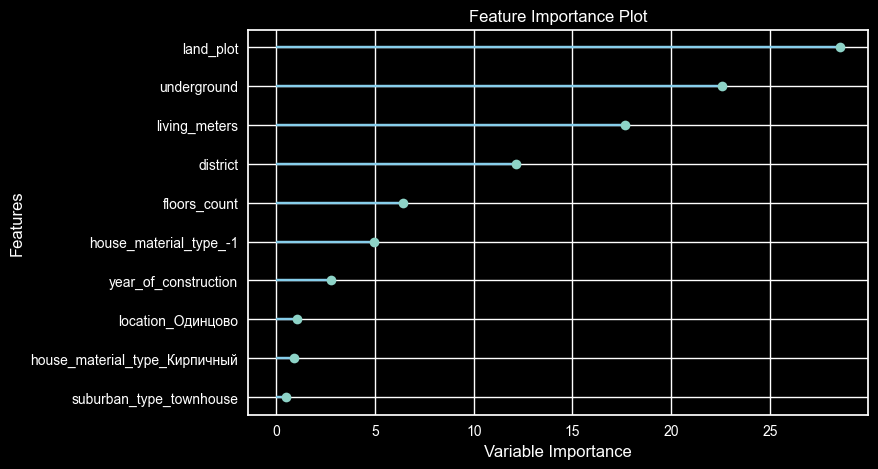

In [330]:
plot_model(best_model,'feature')

In [331]:
predict_model(best_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,19896903.7476,4058053587038200.5000,63702853.8375,0.5822,0.5269,0.5391


,author_type,location,suburban_type,year_of_construction,house_material_type,land_plot,land_plot_status,living_meters,floors_count,district,underground,price,prediction_label
565,real_estate_agent,Москва,house,2005,Кирпичный,19.73,-1,-1.000000,3,р-н Крылатское,м. Крылатское,440000000,1.945032e+08
1220,real_estate_agent,Москва,house,-1,-1,5.00,-1,140.000000,2,Щаповское поселение,м. Охотный ряд,12300000,1.648615e+07
2797,homeowner,Балашиха,townhouse,2020,Газобетонный блок,1.28,-1,100.000000,3,___,м. Железнодорожная,8599999,1.772695e+07
1578,realtor,Москва,house,2006,Кирпичный,15.00,-1,445.200012,3,Марушкинское поселение,___,22000000,4.134961e+07
2089,homeowner,Москва,townhouse,2019,Кирпичный,1.68,-1,91.099998,2,Вороновское поселение,м. Ватутинки,11000000,1.293756e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,real_estate_agent,Москва,house,2020,-1,13.21,-1,50.599998,2,Первомайское поселение,м. Крёкшино,13000000,4.197778e+07
2362,realtor,Долгопрудный,house,-1,-1,12.00,-1,-1.000000,-1,___,м. Водники,53500000,4.532629e+07
1990,realtor,Москва,townhouse,2019,Газобетонный блок,3.00,-1,102.800003,2,Первомайское поселение,м. Крёкшино,15000000,1.358904e+07
1413,realtor,Москва,house,2021,Газосиликатный блок,10.00,-1,200.000000,2,Вороновское поселение,___,16900000,1.894726e+07


In [47]:
final_model = finalize_model(best_model)
save_model(final_model, 'final_model' )

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('iterative_imputer',
                  TransformerWrapper(transformer=IterativeImputer(cat_estimator=XGBClassifier(base_score=None,
                                                                                              booster='gbtree',
                                                                                              callbacks=None,
                                                                                              colsample_bylevel=None,
                                                                                              colsample_bynode=None,
                                                                                              colsample_bytree=None,
                                                                                              device='cpu',
                                                                                              early_stopping_rounds=None,
      

In [115]:
preds = predict_model(best_model)
preds[['price','prediction_label']]/1_000_000

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,15490515.6739,2513763574535590.5000,50137446.8290,-0.0102,0.5609,0.6096


,price,prediction_label
493,175.000000,125.375634
1488,19.300000,20.251941
293,1.574025,4.695171
1600,22.900000,28.373714
1791,29.000000,24.471513
...,...,...
1673,25.000000,26.263499
1769,27.900000,61.463656
107,8.600000,10.675384
607,15.990000,16.440793


In [107]:
final_model = finalize_model(best_model)

#### Оптимизация

In [79]:
%%time
%%chime

tuned_model = exp.tune_model(best_model,n_iter=10, search_library='optuna',search_algorithm='tpe',
                                early_stopping=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,8302307.3244,250098480269820.9688,15814502.2138,0.7928,0.3896,0.3677
1,18197070.4956,5279920749977594.0000,72663063.1750,0.6578,0.4500,0.3910
2,13440712.6368,857921425156238.7500,29290295.7506,0.8716,0.5223,0.4561
3,18119636.6487,3273425689829100.0000,57213859.2461,0.7692,0.4735,0.3612
4,10987934.7207,658093083528068.6250,25653324.9995,0.8558,0.3500,0.3087
5,19103138.4198,3179306617756856.5000,56385340.4508,0.6693,0.4395,0.3660
6,10344612.4511,533259311095380.8125,23092408.0835,0.5123,0.4249,0.3619
7,34367641.1296,22249413238541576.0000,149162372.0599,0.3986,0.5712,0.3853
8,13808224.5434,1418681123040106.7500,37665383.6173,0.3247,0.5060,0.3996


[I 2024-04-23 22:55:21,595] Searching the best hyperparameters using 2051 samples...
[I 2024-04-24 00:31:48,128] Finished hyperparameter search!


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
CPU times: total: 3h 9min 42s
Wall time: 1h 39min 6s


# Разделы ниже будут переработаны

### Без выбросов

In [ ]:
df_without_outliters = (prep_df_fill_cat_nans[prep_df_fill_cat_nans[target]<=50_000_000]
                        .copy().reset_index(drop=True))

In [ ]:
%%chime 

exp = setup(df_without_outliters,target=target, ignore_features = ignore_cols,
            imputation_type = 'iterative', categorical_iterative_imputer = 'xgboost',
            numeric_iterative_imputer = 'xgboost', numeric_features=num_features,
            iterative_imputation_iters = 10, categorical_features=cat_features,
            train_size=0.85, fold=20, session_id=S, normalize=True)
            
best_model = exp.create_model('catboost')

,Description,Value
0,Session id,100500
1,Target,price
2,Target type,Regression
3,Original data shape,"(1402, 27)"
4,Transformed data shape,"(1402, 33)"
5,Transformed train set shape,"(1191, 33)"
6,Transformed test set shape,"(211, 33)"
7,Ignore features,14
8,Numeric features,4
9,Date features,1


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3532237.8104,29078547379697.4336,5392452.8166,0.5830,0.2891,0.2274
1,4489515.5975,33611882612606.6875,5797575.5806,0.4876,0.4054,0.3572
2,4014751.4454,31849253303779.8281,5643514.2689,0.5736,0.3238,0.2560
3,4251325.1924,34890632236813.9531,5906829.2879,0.5244,0.3771,0.3178
4,3919521.3459,33376609796918.8555,5777249.3279,0.5777,0.3796,0.3228
5,4276847.4808,35113184614461.3008,5925637.9078,0.5950,0.3606,0.3168
6,4763475.0108,44965338879537.7109,6705619.9474,0.4185,0.3134,0.2582
7,4445640.9762,35250533737418.2422,5937215.9921,0.4368,0.3740,0.3315
8,4354305.6809,36539135320086.4766,6044760.9812,0.5177,0.3476,0.3089


### Не дорогие дома (меньше 25 млн.)

In [ ]:
low_cost_df = (prep_df_fill_cat_nans[prep_df_fill_cat_nans[target]<=25_000_000]
                        .copy().reset_index(drop=True))

In [ ]:
%%chime 

exp = setup(df_without_outliters,target=target, ignore_features = ignore_cols,
            imputation_type = 'iterative', categorical_iterative_imputer = 'xgboost',
            numeric_iterative_imputer = 'xgboost', numeric_features=num_features,
            iterative_imputation_iters = 10, categorical_features=cat_features,
            train_size=0.85, fold=20, session_id=S, normalize=True)
            
best_model = exp.create_model('catboost')

,Description,Value
0,Session id,100500
1,Target,price
2,Target type,Regression
3,Original data shape,"(1402, 27)"
4,Transformed data shape,"(1402, 33)"
5,Transformed train set shape,"(1191, 33)"
6,Transformed test set shape,"(211, 33)"
7,Ignore features,14
8,Numeric features,4
9,Date features,1


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3532237.8104,29078547379697.4336,5392452.8166,0.5830,0.2891,0.2274
1,4489515.5975,33611882612606.6875,5797575.5806,0.4876,0.4054,0.3572
2,4014751.4454,31849253303779.8281,5643514.2689,0.5736,0.3238,0.2560
3,4251325.1924,34890632236813.9531,5906829.2879,0.5244,0.3771,0.3178
4,3919521.3459,33376609796918.8555,5777249.3279,0.5777,0.3796,0.3228
5,4276847.4808,35113184614461.3008,5925637.9078,0.5950,0.3606,0.3168
6,4763475.0108,44965338879537.7109,6705619.9474,0.4185,0.3134,0.2582
7,4445640.9762,35250533737418.2422,5937215.9921,0.4368,0.3740,0.3315
8,4354305.6809,36539135320086.4766,6044760.9812,0.5177,0.3476,0.3089


### Далее